# Libraries Import

In [502]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.stats import f_oneway

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# Read the CSV file

In [503]:
user_transactions_raw_df = pd.read_csv('user_transactions.csv',delimiter=',')
user_transactions_raw_df.head(15)

,Transaction ID,User ID,Transaction Date,Transaction Time,Product ID,Product Price,Quantity,Discount Applied,Payment Method,User Age,User Gender,User Location,User Membership Status,Device Used,Referral Source,Transaction Status,User Tenure,Product Category,Amount
0,1,4047,2023-11-26,14:18:07,1029,125.70,1,5,Credit Card,30,Female,Athens,Regular,Desktop,Social Media,Completed,42,Clothing,125.70
1,2,4430,2023-11-25,06:44:25,1050,80.10,2,5,PayPal,25,Male,Athens,Premium,Desktop,Social Media,Completed,16,Electronics,160.20
2,3,3759,2023-09-16,20:43:25,1095,81.40,2,5,Credit Card,42,Male,Patras,Premium,Mobile,Social Media,Completed,12,Books,162.80
3,4,1598,2023-12-21,09:11:03,1000,89.45,2,5,PayPal,39,Female,Thessaloniki,Regular,Mobile,Social Media,Completed,32,Clothing,178.90
4,5,6531,2023-01-23,16:22:27,1019,147.90,3,0,Credit Card,39,Male,Athens,Premium,Desktop,Social Media,Completed,1,Books,443.70
5,6,20355,2023-12-03,23:25:21,1026,134.50,2,20,Credit Card,35,Male,Athens,Premium,Mobile,Social Media,Completed,16,Home & Kitchen,269.00
6,7,8579,2023-02-22,19:23:47,1022,109.30,2,5,Credit Card,27,Male,Athens,Regular,Mobile,Organic,Completed,20,Clothing,218.60
7,8,4114,2023-09-20,07:07:43,1037,129.30,2,5,Credit Card,36,Female,Athens,Regular,Mobile,Referral,Completed,54,Books,258.60
8,9,9775,2023-12-03,10:55:26,1002,135.90,2,15,Credit Card,35,Male,Athens,Regular,Desktop,Social Media,Completed,11,Electronics,271.80
9,10,4903,2023-12-24,06:49:57,1096,71.50,2,5,Credit Card,29,Male,Athens,Regular,Mobile,Social Media,Completed,54,Clothing,143.00


# Data Preprocessing & Exploratory Data Analysis (EDA) &  Pattern and Insight Discovery:

In [504]:
mean_tenure = 29.9
std_tenure = 17.20

def tenure_category(tenure):
    if tenure < mean_tenure:
        return 'Low'
    elif tenure >= mean_tenure and tenure < (mean_tenure + std_tenure):
        return 'Medium'
    else:
        return 'High'

In [505]:
user_transactions_df = user_transactions_raw_df.copy()
user_transactions_df['Transaction DateTime'] = pd.to_datetime(user_transactions_df['Transaction Date'] + ' ' + user_transactions_df['Transaction Time'])
user_transactions_df.drop(['Transaction Date', 'Transaction Time'], axis=1, inplace=True)
user_transactions_df['Year'] = user_transactions_df['Transaction DateTime'].dt.year.astype(int)
user_transactions_df['Month'] = user_transactions_df['Transaction DateTime'].dt.month.astype(int)
user_transactions_df['Day'] = user_transactions_df['Transaction DateTime'].dt.day.astype(int)
user_transactions_df['Hour'] = user_transactions_df['Transaction DateTime'].dt.hour.astype(int)
user_transactions_df['Transaction DateTime'] = pd.to_datetime(user_transactions_df[['Year', 'Month', 'Day', 'Hour']])
bins = [user_transactions_df['User Age'].min(), 30, 40, 50, user_transactions_df['User Age'].max()]
labels = ['min-30', '30-40', '40-50', '50-max']
user_transactions_df['Age_groups'] = pd.cut(user_transactions_df['User Age'], bins=bins, labels=labels, right=False)
user_transactions_df['Tenure_Category'] = user_transactions_df['User Tenure'].apply(tenure_category)

user_transactions_df.head(5)

,Transaction ID,User ID,Product ID,Product Price,Quantity,Discount Applied,Payment Method,User Age,User Gender,User Location,User Membership Status,Device Used,Referral Source,Transaction Status,User Tenure,Product Category,Amount,Transaction DateTime,Year,Month,Day,Hour,Age_groups,Tenure_Category
0,1,4047,1029,125.70,1,5,Credit Card,30,Female,Athens,Regular,Desktop,Social Media,Completed,42,Clothing,125.7,2023-11-26 14:00:00,2023,11,26,14,30-40,Medium
1,2,4430,1050,80.10,2,5,PayPal,25,Male,Athens,Premium,Desktop,Social Media,Completed,16,Electronics,160.2,2023-11-25 06:00:00,2023,11,25,6,min-30,Low
2,3,3759,1095,81.40,2,5,Credit Card,42,Male,Patras,Premium,Mobile,Social Media,Completed,12,Books,162.8,2023-09-16 20:00:00,2023,9,16,20,40-50,Low
3,4,1598,1000,89.45,2,5,PayPal,39,Female,Thessaloniki,Regular,Mobile,Social Media,Completed,32,Clothing,178.9,2023-12-21 09:00:00,2023,12,21,9,30-40,Medium
4,5,6531,1019,147.90,3,0,Credit Card,39,Male,Athens,Premium,Desktop,Social Media,Completed,1,Books,443.7,2023-01-23 16:00:00,2023,1,23,16,30-40,Low


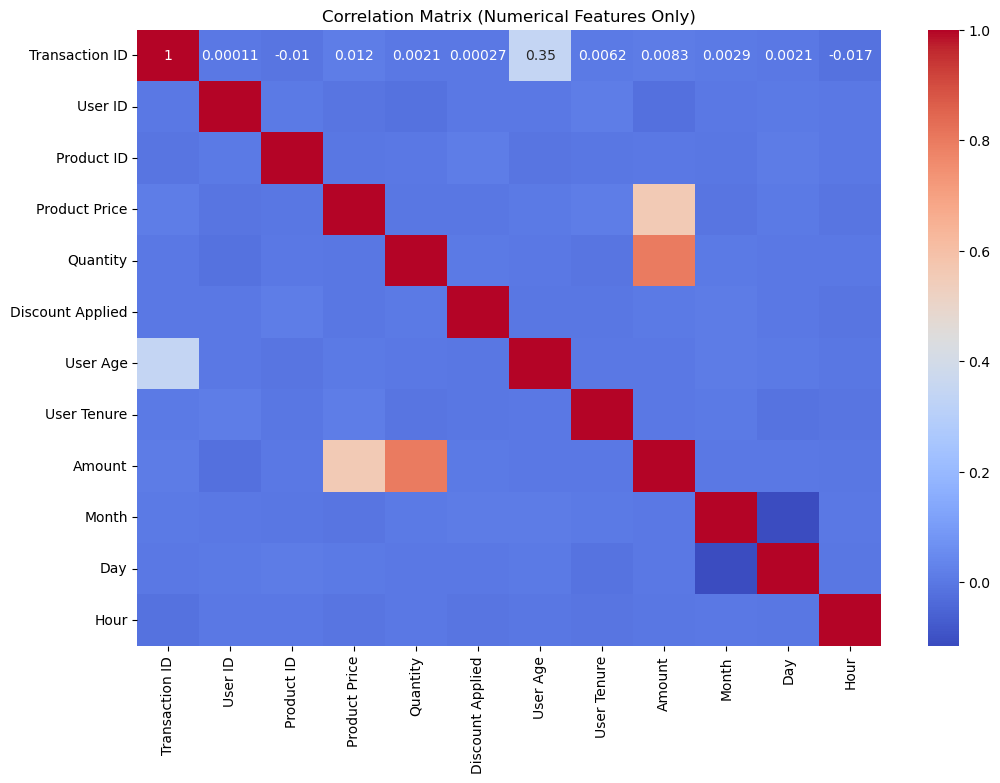

In [506]:
numerical_df = user_transactions_df.select_dtypes(include=['number'])
numerical_df = numerical_df.drop(columns='Year')
# correlation matrix fir numerical values
corr_matrix = numerical_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Features Only)')
plt.show()


In [507]:
final_df = numerical_df.drop(columns=['Transaction ID','User ID','Product ID'])
final_df.head(10)

,Product Price,Quantity,Discount Applied,User Age,User Tenure,Amount,Month,Day,Hour
0,125.70,1,5,30,42,125.7,11,26,14
1,80.10,2,5,25,16,160.2,11,25,6
2,81.40,2,5,42,12,162.8,9,16,20
3,89.45,2,5,39,32,178.9,12,21,9
4,147.90,3,0,39,1,443.7,1,23,16
5,134.50,2,20,35,16,269.0,12,3,23
6,109.30,2,5,27,20,218.6,2,22,19
7,129.30,2,5,36,54,258.6,9,20,7
8,135.90,2,15,35,11,271.8,12,3,10
9,71.50,2,5,29,54,143.0,12,24,6


# Clustering Analysis:

## K-Means(Only numerical columns)

In [508]:
np.random.seed(42)

# Select features to be standardized
#features = ['Product Price', 'Quantity', 'Discount Applied', 'User Age', 'User Tenure', 'Amount', 'Month', 'Day', 'Hour']
#features = ['Quantity', 'User Age', 'Hour']
#features = ['Product Price', 'Discount Applied', 'User Age', 'User Tenure', 'Day']
#features = ['Discount Applied', 'Amount', 'Day', 'Hour']
#features = ['User Tenure', 'Amount', 'Month', 'Day'] !
#features = ['Product Price', 'Discount Applied', 'User Age', 'Month']
#features = ['Product Price', 'Quantity', 'Discount Applied', 'User Age', 'Hour']
#features = ['Product Price', 'Quantity', 'Amount']
#features = ['Product Price', 'Discount Applied', 'Amount']
#features = ['Discount Applied', 'User Age', 'User Tenure', 'Day']
#features = ['Quantity', 'User Tenure', 'Month', 'Hour'] !!
#features = ['Quantity', 'User Age', 'User Tenure'] !
#features = ['Product Price', 'Quantity', 'Day']
#features = ['User Age', 'User Tenure', 'Amount']
#features = ['Discount Applied', 'User Tenure', 'Day', 'Hour']
#features = ['Quantity', 'User Age', 'Amount', 'Hour']
features = ['Discount Applied', 'User Tenure','User Age', 'Day', 'Hour']

# standardize the features
scaler = StandardScaler()
final_standardized_data = scaler.fit_transform(final_df[features])


In [509]:
# apply PCA
pca = PCA(n_components=2)  # reduce to 2 dimensions for visualization
pca_data = pca.fit_transform(final_standardized_data)

# create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_data, columns=['Principal Component 1', 'Principal Component 2'])


c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

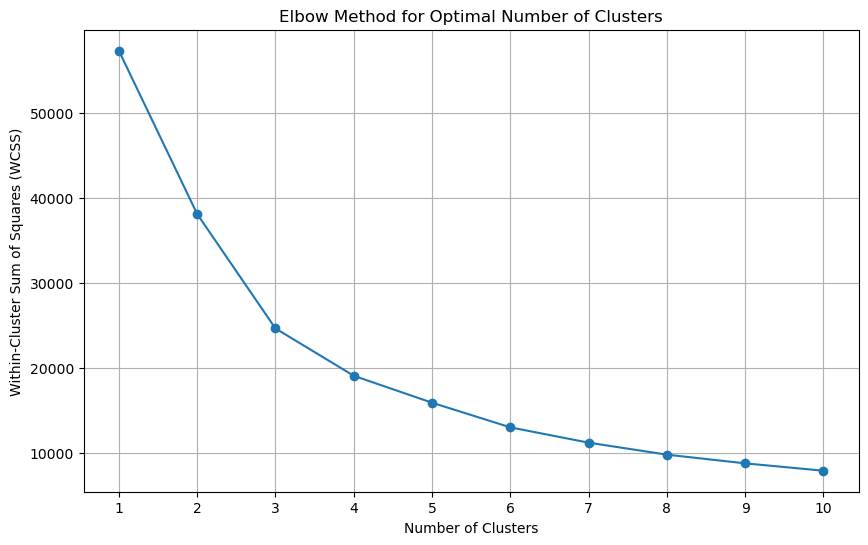

In [510]:
# elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

# elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [511]:
# apply k-means 
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(pca_df)
pca_df['Cluster'] = kmeans.labels_


c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


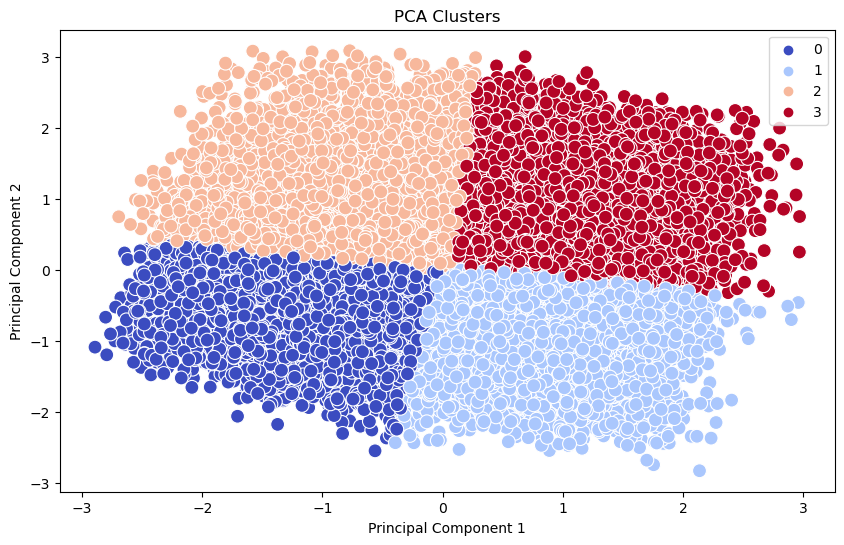

In [512]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='Principal Component 1', y='Principal Component 2', hue='Cluster', palette='coolwarm', s=100)
plt.title('PCA Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()



#### One hot encoding

In [513]:
dummy_columns = ['Payment Method', 'User Gender', 'User Location', 'User Membership Status', 
                 'Device Used', 'Referral Source','Transaction Status', 'Product Category','Tenure_Category']


user_transactions_encoded_df = pd.get_dummies(user_transactions_df, columns=dummy_columns)
user_transactions_encoded_df.head(3)

,Transaction ID,User ID,Product ID,Product Price,Quantity,Discount Applied,User Age,User Tenure,Amount,Transaction DateTime,Year,Month,Day,Hour,Age_groups,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_PayPal,User Gender_Female,User Gender_Male,User Location_Athens,User Location_Chalkida,User Location_Heraklion,User Location_Patras,User Location_Thessaloniki,User Membership Status_Premium,User Membership Status_Regular,Device Used_Desktop,Device Used_Mobile,Referral Source_Organic,Referral Source_Referral,Referral Source_Social Media,Transaction Status_Canceled,Transaction Status_Completed,Transaction Status_Pending,Product Category_Books,Product Category_Clothing,Product Category_Electronics,Product Category_Home & Kitchen,Product Category_Sports,Tenure_Category_High,Tenure_Category_Low,Tenure_Category_Medium
0,1,4047,1029,125.7,1,5,30,42,125.7,2023-11-26 14:00:00,2023,11,26,14,30-40,True,False,False,True,False,True,False,False,False,False,False,True,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,True
1,2,4430,1050,80.1,2,5,25,16,160.2,2023-11-25 06:00:00,2023,11,25,6,min-30,False,False,True,False,True,True,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False
2,3,3759,1095,81.4,2,5,42,12,162.8,2023-09-16 20:00:00,2023,9,16,20,40-50,True,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,True,False,True,False,True,False,False,False,False,False,True,False


In [514]:


dummy_columns = ['Payment Method_Credit Card', 'Payment Method_Debit Card', 'Payment Method_PayPal',
                 'User Gender_Male', 'User Gender_Female', 'User Location_Athens', 'User Location_Chalkida', 'User Location_Heraklion',
                 'User Location_Patras', 'User Location_Thessaloniki', 'User Membership Status_Premium',
                 'User Membership Status_Regular', 'Device Used_Desktop', 'Device Used_Mobile', 'Referral Source_Organic',
                 'Referral Source_Referral', 'Referral Source_Social Media', 'Transaction Status_Canceled',
                 'Transaction Status_Completed', 'Transaction Status_Pending', 'Product Category_Books',
                 'Product Category_Clothing', 'Product Category_Electronics',
                 'Product Category_Home & Kitchen', 'Product Category_Sports',
                 'Tenure_Category_High','Tenure_Category_Low','Tenure_Category_Medium']

user_transactions_encoded_df = user_transactions_encoded_df.drop(columns=['Transaction ID','Transaction DateTime','Year'])
user_transactions_encoded_df[dummy_columns] = user_transactions_encoded_df[dummy_columns].astype(int)

user_transactions_encoded_df.head(10)

,User ID,Product ID,Product Price,Quantity,Discount Applied,User Age,User Tenure,Amount,Month,Day,Hour,Age_groups,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_PayPal,User Gender_Female,User Gender_Male,User Location_Athens,User Location_Chalkida,User Location_Heraklion,User Location_Patras,User Location_Thessaloniki,User Membership Status_Premium,User Membership Status_Regular,Device Used_Desktop,Device Used_Mobile,Referral Source_Organic,Referral Source_Referral,Referral Source_Social Media,Transaction Status_Canceled,Transaction Status_Completed,Transaction Status_Pending,Product Category_Books,Product Category_Clothing,Product Category_Electronics,Product Category_Home & Kitchen,Product Category_Sports,Tenure_Category_High,Tenure_Category_Low,Tenure_Category_Medium
0,4047,1029,125.70,1,5,30,42,125.7,11,26,14,30-40,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1
1,4430,1050,80.10,2,5,25,16,160.2,11,25,6,min-30,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
2,3759,1095,81.40,2,5,42,12,162.8,9,16,20,40-50,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0
3,1598,1000,89.45,2,5,39,32,178.9,12,21,9,30-40,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1
4,6531,1019,147.90,3,0,39,1,443.7,1,23,16,30-40,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0
5,20355,1026,134.50,2,20,35,16,269.0,12,3,23,30-40,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0
6,8579,1022,109.30,2,5,27,20,218.6,2,22,19,min-30,1,0,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0
7,4114,1037,129.30,2,5,36,54,258.6,9,20,7,30-40,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0
8,9775,1002,135.90,2,15,35,11,271.8,12,3,10,30-40,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
9,4903,1096,71.50,2,5,29,54,143.0,12,24,6,min-30,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0


In [515]:
final_encoded_df = user_transactions_encoded_df.drop(columns=['User ID','Product ID','Age_groups'])#,,'Tenure_Category'])
final_encoded_df.head(10)

,Product Price,Quantity,Discount Applied,User Age,User Tenure,Amount,Month,Day,Hour,Payment Method_Credit Card,Payment Method_Debit Card,Payment Method_PayPal,User Gender_Female,User Gender_Male,User Location_Athens,User Location_Chalkida,User Location_Heraklion,User Location_Patras,User Location_Thessaloniki,User Membership Status_Premium,User Membership Status_Regular,Device Used_Desktop,Device Used_Mobile,Referral Source_Organic,Referral Source_Referral,Referral Source_Social Media,Transaction Status_Canceled,Transaction Status_Completed,Transaction Status_Pending,Product Category_Books,Product Category_Clothing,Product Category_Electronics,Product Category_Home & Kitchen,Product Category_Sports,Tenure_Category_High,Tenure_Category_Low,Tenure_Category_Medium
0,125.70,1,5,30,42,125.7,11,26,14,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1
1,80.10,2,5,25,16,160.2,11,25,6,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
2,81.40,2,5,42,12,162.8,9,16,20,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0
3,89.45,2,5,39,32,178.9,12,21,9,0,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1
4,147.90,3,0,39,1,443.7,1,23,16,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0
5,134.50,2,20,35,16,269.0,12,3,23,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0
6,109.30,2,5,27,20,218.6,2,22,19,1,0,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0
7,129.30,2,5,36,54,258.6,9,20,7,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0
8,135.90,2,15,35,11,271.8,12,3,10,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
9,71.50,2,5,29,54,143.0,12,24,6,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0


In [516]:
np.random.seed(42)

In [517]:

features = [
    'Product Price', 'Quantity', 'Discount Applied', 
    'User Age', 'User Tenure', 'Amount','Month', #'Hour', 
    'Day',
    #'Payment Method_Credit Card', 'Payment Method_Debit Card', 'Payment Method_PayPal',
    'User Gender_Female', 'User Gender_Male',
    #'User Location_Athens', 'User Location_Chalkida', 'User Location_Heraklion', 'User Location_Patras', 'User Location_Thessaloniki',
    #'User Membership Status_Premium', 'User Membership Status_Regular',
    #'Device Used_Desktop', 'Device Used_Mobile',
    #'Referral Source_Organic', 'Referral Source_Referral', 'Referral Source_Social Media',
    #'Transaction Status_Canceled', 'Transaction Status_Completed', 'Transaction Status_Pending',
    'Product Category_Books', 'Product Category_Clothing', 'Product Category_Electronics', 'Product Category_Home & Kitchen', 'Product Category_Sports',
                 'Tenure_Category_High','Tenure_Category_Low','Tenure_Category_Medium'
]

'''
features = [
    'Product Price', 'Quantity', 'User Age', 'User Tenure', 'Amount', 'Month', 'Hour',
    'Payment Method_Credit Card', 'Payment Method_Debit Card', 'Payment Method_PayPal',
    'User Gender_Female', 'User Gender_Male',
    'User Location_Athens', 'User Location_Chalkida', 'User Location_Heraklion', 'User Location_Patras', 'User Location_Thessaloniki',
    'Transaction Status_Canceled', 'Transaction Status_Completed', 'Transaction Status_Pending',
    'Product Category_Books', 'Product Category_Electronics', 'Product Category_Home & Kitchen', 'Product Category_Sports'
]
'''

# Standardize the features
scaler = StandardScaler()
final_standardized_data = scaler.fit_transform(final_encoded_df[features])

### K-Means (all the features)

In [518]:
# apply PCA
pca = PCA(n_components=2)  # reduce to 2 dimensions for visualization
pca_data = pca.fit_transform(final_standardized_data)

# create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_data, columns=['Principal Component 1', 'Principal Component 2'])

c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

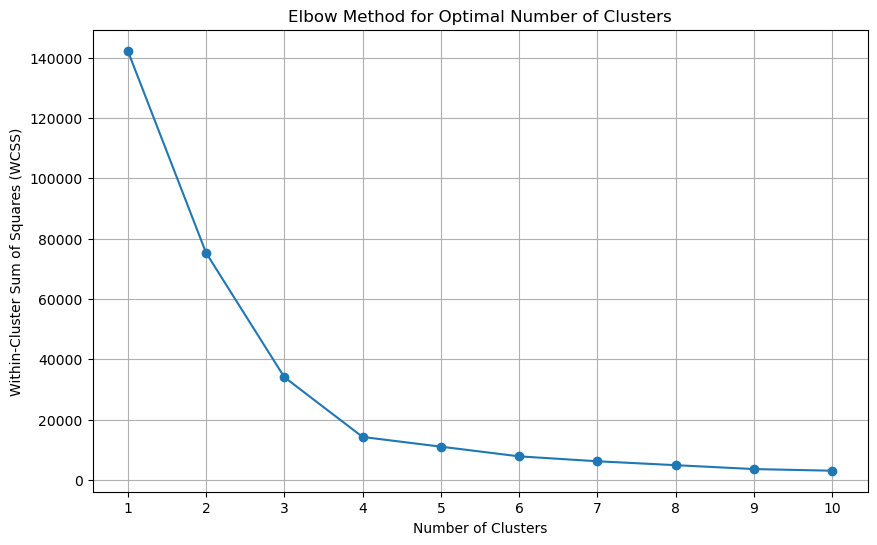

In [519]:
# elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

# elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


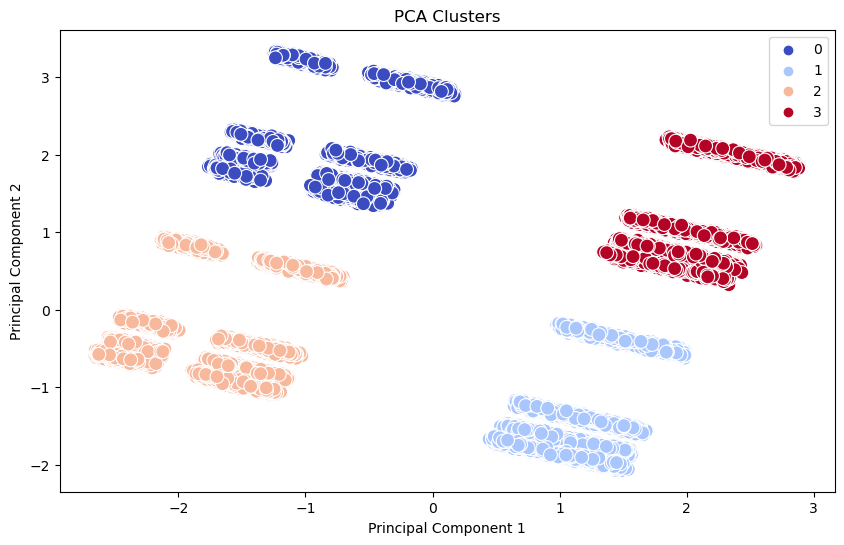

In [520]:
# apply k-means
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(pca_df)
pca_df['Cluster'] = kmeans.labels_

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='Principal Component 1', y='Principal Component 2', hue='Cluster', palette='coolwarm', s=100)
plt.title('PCA Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### DB SCAN (All the features)

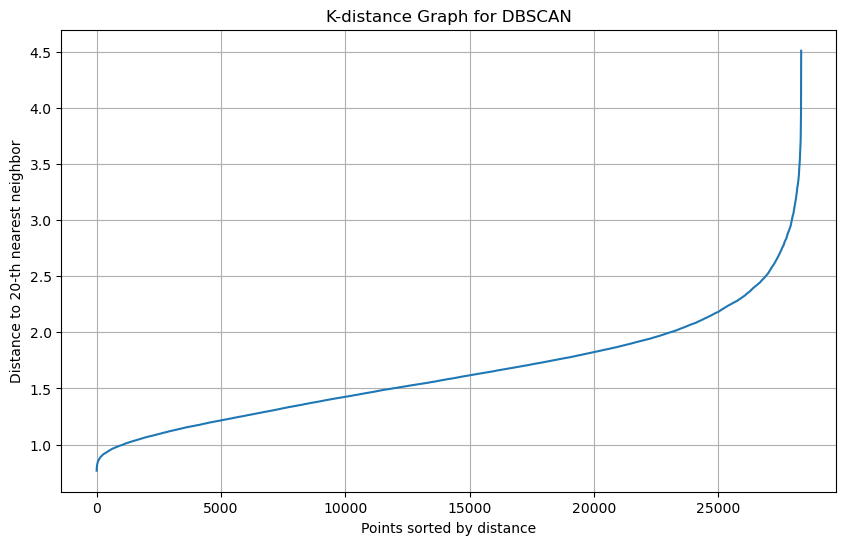

In [521]:
# distance to the nearest neighbors
min_samples = 20
nearest_neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = nearest_neighbors.fit(final_standardized_data)
distances, indices = neighbors_fit.kneighbors(final_standardized_data)
distances = np.sort(distances[:, min_samples-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph for DBSCAN')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to {}-th nearest neighbor'.format(min_samples))
plt.grid(True)
plt.show()

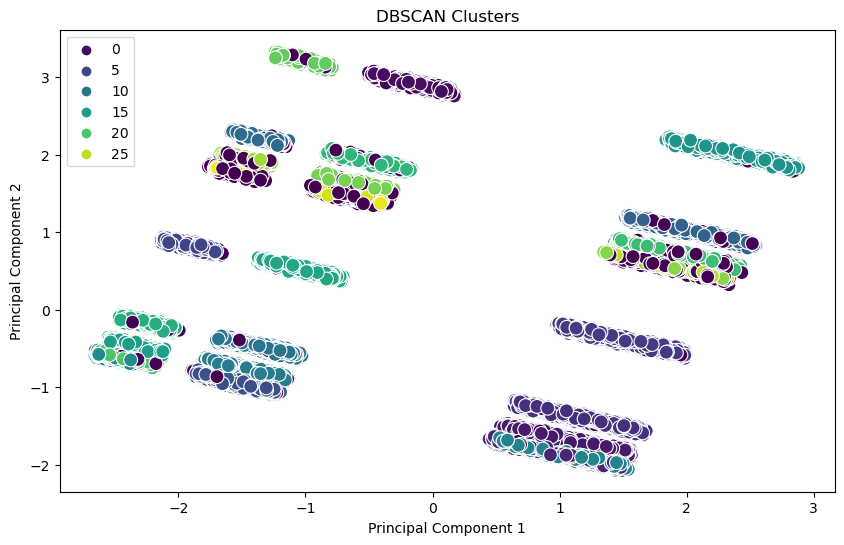

In [522]:
# apply DBSCAN
dbscan = DBSCAN(eps=2, min_samples=20)
cluster_labels = dbscan.fit_predict(final_standardized_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='Principal Component 1', y='Principal Component 2', hue=cluster_labels, palette='viridis', s=100)
plt.title('DBSCAN Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [523]:
final_encoded_df['Cluster'] = kmeans.labels_

# summary statistics for each cluster
cluster_summary = final_encoded_df.groupby('Cluster').mean()
cluster_summary.T


Cluster,0,1,2,3
Product Price,110.518489,110.158037,110.782571,109.894909
Quantity,2.266091,2.289318,2.271026,2.286121
Discount Applied,11.078591,11.367443,11.187917,11.043891
User Age,36.589319,36.400735,36.408779,36.436536
User Tenure,44.571828,14.814747,44.761521,14.875208
Amount,250.354146,251.818927,251.286788,251.905288
Month,8.161381,8.079861,8.138748,8.032028
Day,16.414412,16.462623,16.250523,16.519573
Hour,11.522854,11.585784,11.553598,11.534282
Payment Method_Credit Card,0.780784,0.768791,0.770180,0.761566


c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\glevantis\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

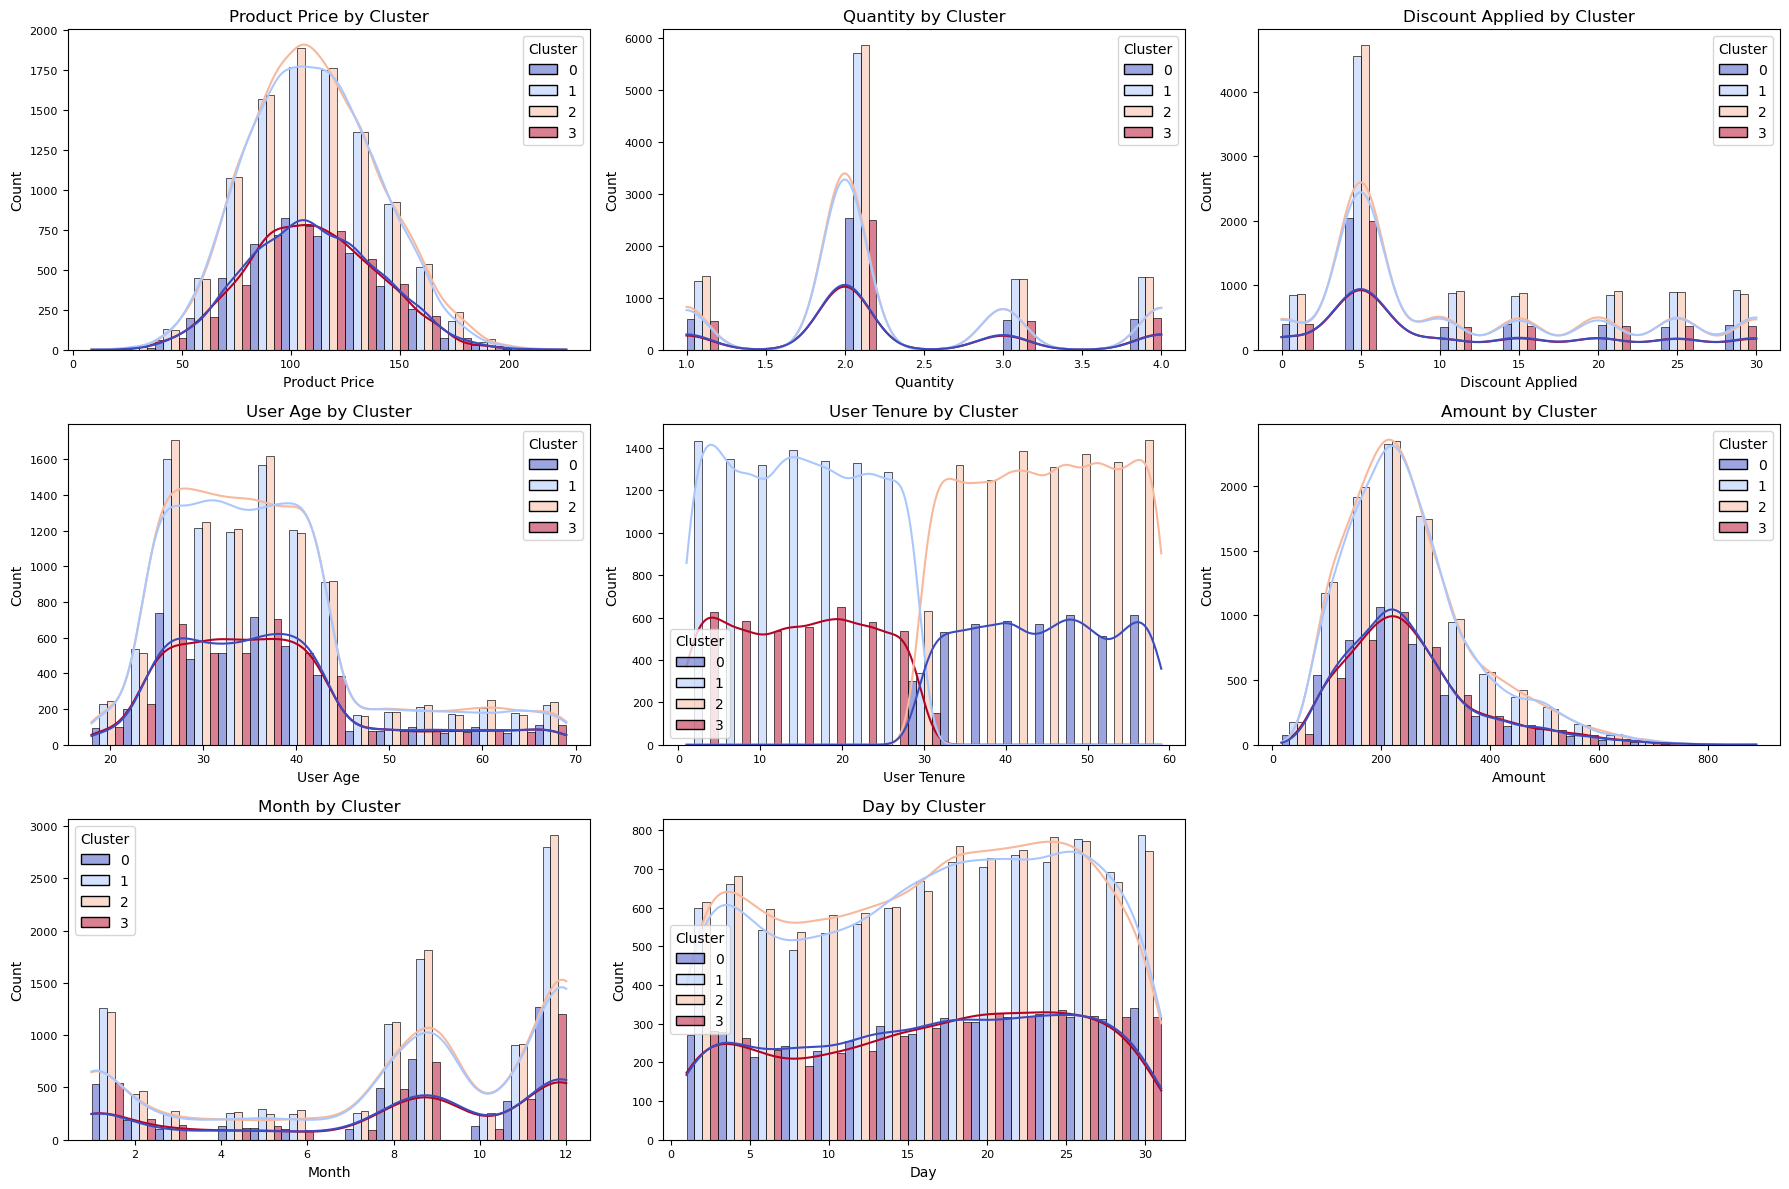

In [524]:
# numerical features
numerical_features = ['Product Price', 
                      'Quantity', 
                      'Discount Applied', 
                      'User Age', 
                      'User Tenure', 
                      'Amount',
                      'Month',
                      'Day',
                      #'Hour'
                      ]

num_cols = 3  
num_rows = len(numerical_features) // num_cols + (len(numerical_features) % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(data=final_encoded_df, x=feature, hue='Cluster', multiple='dodge', bins=15, kde=True, ax=axes[i], palette='coolwarm')
    axes[i].set_title(f'{feature} by Cluster', fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Count', fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)







for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


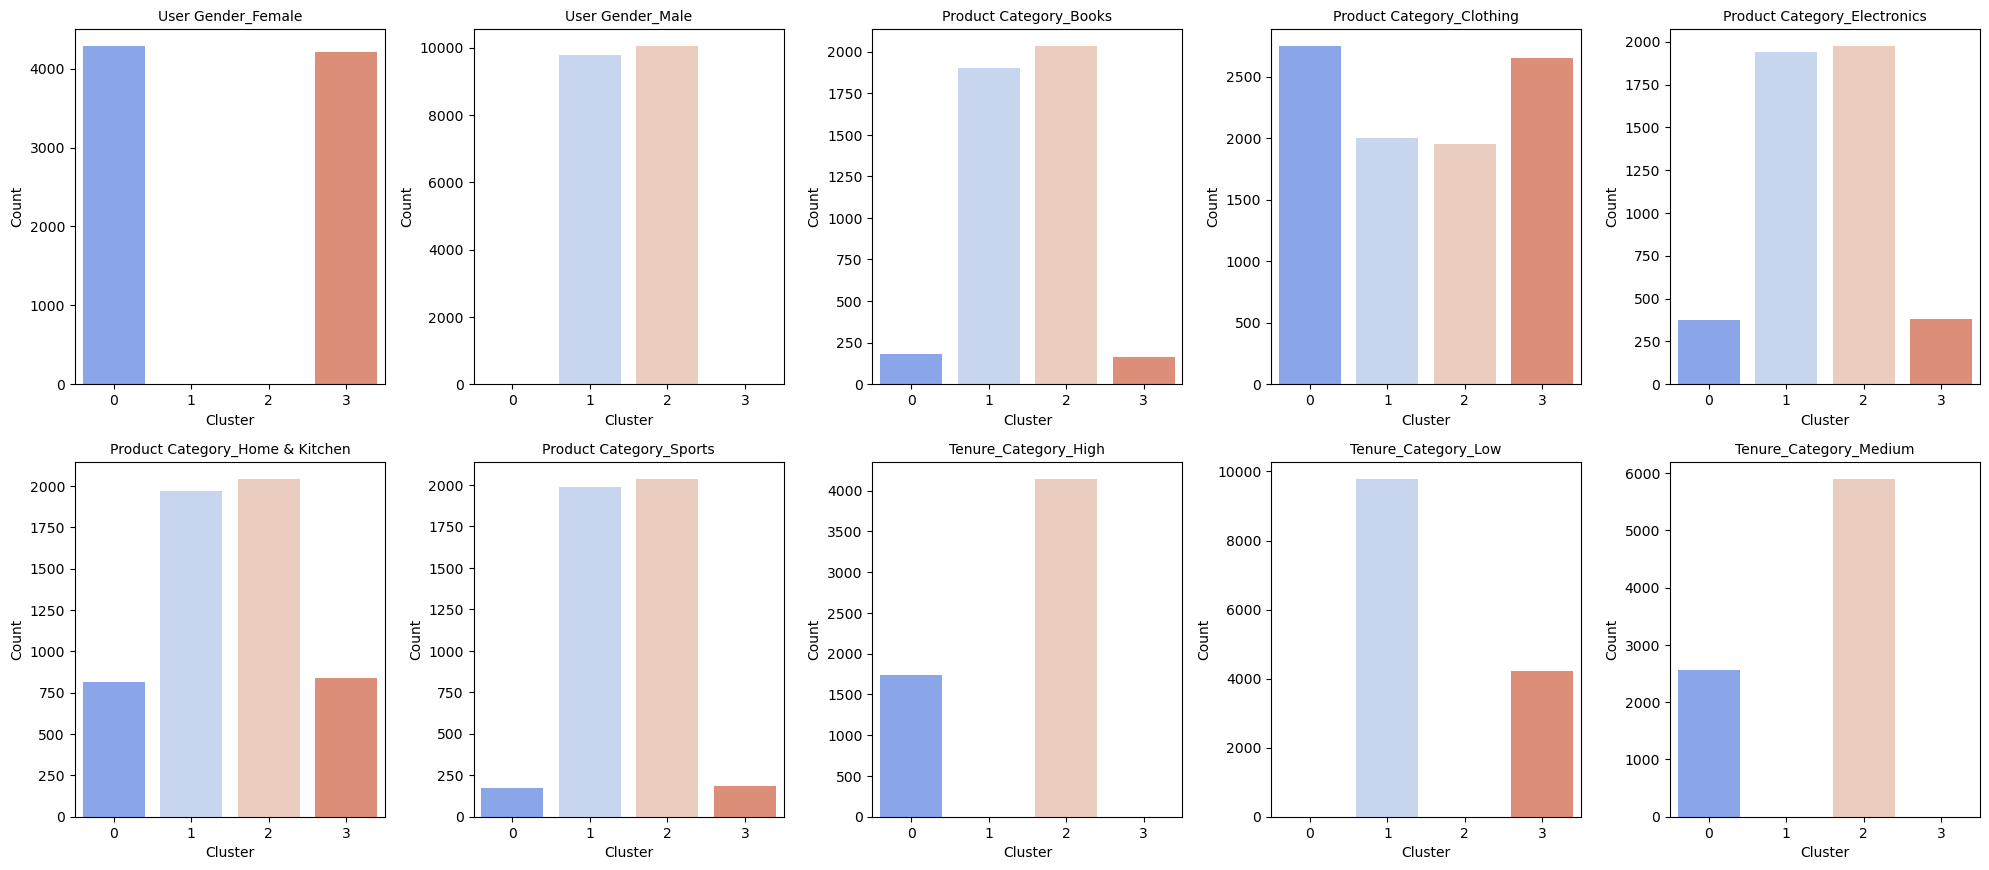

In [525]:
# group by cluster and sum the binary columns
cluster_aggregates = final_encoded_df.groupby('Cluster').sum()

# one-hot encoded features
one_hot_features = [
    #'Payment Method_Credit Card', 'Payment Method_Debit Card', 'Payment Method_PayPal',
    'User Gender_Female', 'User Gender_Male',
    #'User Location_Athens', 'User Location_Chalkida', 'User Location_Heraklion', 'User Location_Patras', 'User Location_Thessaloniki',
    #'User Membership Status_Premium', 'User Membership Status_Regular',
    #'Device Used_Desktop', 'Device Used_Mobile',
    #'Referral Source_Organic', 'Referral Source_Referral', 'Referral Source_Social Media',
    #'Transaction Status_Canceled', 'Transaction Status_Completed', 'Transaction Status_Pending',
    'Product Category_Books', 'Product Category_Clothing', 'Product Category_Electronics', 'Product Category_Home & Kitchen', 'Product Category_Sports',
    'Tenure_Category_High','Tenure_Category_Low','Tenure_Category_Medium']

plt.figure(figsize=(20, 30))
for i, feature in enumerate(one_hot_features):
    plt.subplot(7, 5, i + 1)
    sns.barplot(x=cluster_aggregates.index, y=cluster_aggregates[feature],palette='coolwarm')
    plt.title(f'{feature}', fontsize=10)
    plt.xlabel('Cluster')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()



Product Price: F-statistic = 1.2100, p-value = 0.3043
Quantity: F-statistic = 1.1471, p-value = 0.3285
Discount Applied: F-statistic = 1.7001, p-value = 0.1646
User Age: F-statistic = 0.3571, p-value = 0.7840
User Tenure: F-statistic = 28911.1443, p-value = 0.0000
Amount: F-statistic = 0.1762, p-value = 0.9126
Month: F-statistic = 1.1958, p-value = 0.3096
Day: F-statistic = 1.4066, p-value = 0.2387
Significant features: ['User Tenure']
        User Tenure                         
               mean median       std min max
Cluster                                     
0         44.571828   45.0  8.675928  30  59
1         14.814747   15.0  8.372970   1  29
2         44.761521   45.0  8.693252  30  59
3         14.875208   15.0  8.398058   1  29


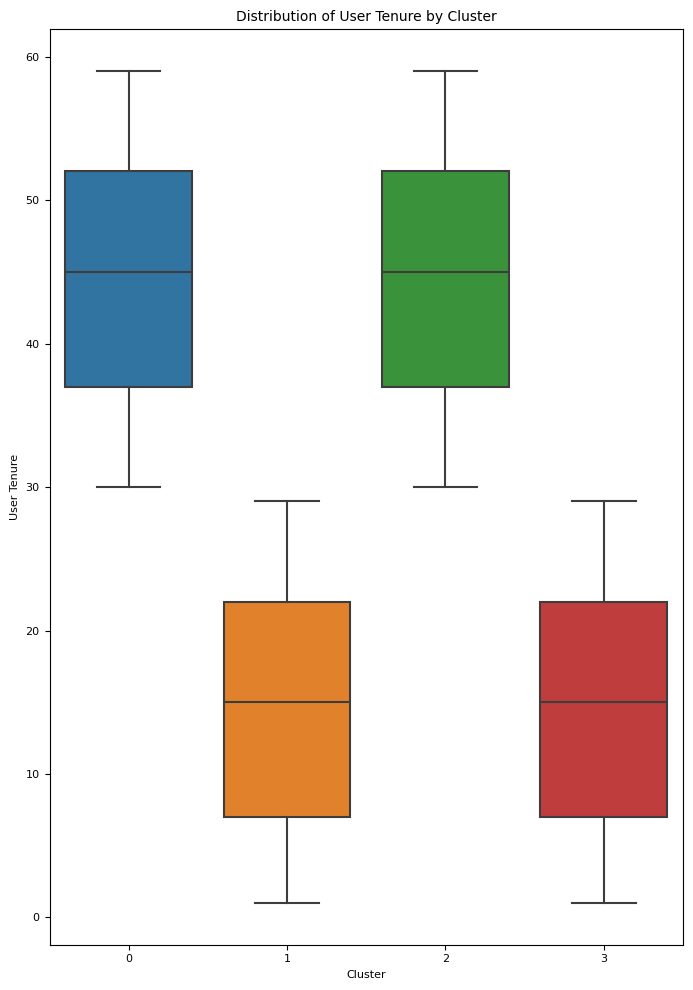

In [527]:
'''
# ANOVA for numerical features
anova_results = {feature: f_oneway(*[final_encoded_df[final_encoded_df['Cluster'] == cluster][feature] for cluster in final_encoded_df['Cluster'].unique()]) for feature in numerical_features}

for feature, result in anova_results.items():
    print(f"{feature}: F-statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")
    
alpha = 0.05

# significant features
significant_features = [feature for feature, result in anova_results.items() if result.pvalue < alpha]
print("Significant features:", significant_features)

cluster_summary = final_encoded_df.groupby('Cluster')[significant_features].agg(['mean', 'median', 'std', 'min', 'max'])
print(cluster_summary)

# significant features by cluster
plt.figure(figsize=(20, 10))
for i, feature in enumerate(significant_features):
    plt.subplot(len(significant_features) // 3 + 1, 3, i + 1)
    sns.boxplot(x='Cluster', y=feature, data=final_encoded_df)
    plt.title(f'Distribution of {feature} by Cluster', fontsize=10)
    plt.xlabel('Cluster', fontsize=8)
    plt.ylabel(feature, fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()
'''
